In [19]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from shapely import affinity
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon

mpl.style.use('seaborn')


class Graph:
  def __init__(self, x_coords=None, y_coords=None, source_coords=None, dest_coords=None, dest_radius=None):
    
    self.zeta = 27
    
    (self.x, self.y) = (np.arange(0,50,0.5), np.arange(0,50,0.5)) if x_coords is None or y_coords is None else (x_coords, y_coords)
    self.X, self.Y = np.meshgrid(self.x, self.y)

    # source and destination coordinates
    (self.X_s, self.Y_s) = (0.5, 0.5) if source_coords is None else (source_coords[0], source_coords[1])
    (self.X_d, self.Y_d) = (45, 41) if dest_coords is None else (dest_coords[0], dest_coords[1])
    
    # destination radius
    self.R_d = 1 if dest_radius is None else dest_radius
    
    self.obstacles = []                   # list of obstacles
    
    self.F_x = np.zeros(self.X.shape)     # field strength in x-direction
    self.F_y = np.zeros(self.Y.shape)     # field strength in y-direction
  
  def add_obstacle(self, obst):
    self.obstacles.append(obst)
    self.setup_field(obst)
  
  def setup_field(self, obst):
    for i in range(len(self.x)):
      for j in range(len(self.y)):
        fx, fy= obst.calc_F(self.X[i,j], self.Y[i,j])
        self.F_x[i,j] -= fx
        self.F_y[i,j] -= fy
    
    _zeta_ = 0
    for obst in self.obstacles:
      l = LineString(obst.vertices + [obst.vertices[0]]).length if obst.shape == 'polygon' else 2*np.pi*obst.radius
      _zeta_ += obst.eta * l
    
    _zeta_ *= self.zeta

    for i in range(len(self.x)):
      for j in range(len(self.y)):
        d_dest = np.sqrt((self.X[i][j] - self.X_d)**2 + (self.Y[i][j] - self.Y_d)**2)
        if d_dest < self.R_d:
          self.F_x[i][j] -= _zeta_*(self.X[i][j] - self.X_d)/self.R_d
          self.F_y[i][j] -= _zeta_*(self.Y[i][j] - self.Y_d)/self.R_d
        else:
          self.F_x[i][j] -= _zeta_*(self.X[i][j] - self.X_d)/d_dest
          self.F_y[i][j] -= _zeta_*(self.Y[i][j] - self.Y_d)/d_dest
  
  def plot(self, title=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # mark source
    plt.plot(self.X_s, self.Y_s, 'C0o')
    
    # mark destination
    plt.plot(self.X_d, self.Y_d, 'C1o')
    ax.add_patch(plt.Circle((self.X_d, self.Y_d), self.R_d, color='C1', alpha=0.5))
    
    # mark obstacles
    for obst in self.obstacles:
      if obst.shape == 'circle':
        ax.add_patch(plt.Circle(obst.centre, obst.radius, color='C2'))
        ax.add_patch(plt.Circle(obst.centre, obst.radius*(1+obst.delta), color='C2', alpha=0.2))
      else:
        ax.add_patch(plt.Polygon((obst.vertices), color ='C2'))
        outer_poly = affinity.scale(Polygon(obst.vertices), xfact=1+obst.delta, yfact=1+obst.delta, origin='centroid')
        ax.add_patch(plt.Polygon((outer_poly.exterior.coords), color ='C2', alpha=0.2))
    
    # plot field
    plt.quiver(self.X, self.Y, self.F_x, self.F_y, color='grey')

    # plot path
    ax.streamplot(self.X, self.Y, self.F_x, self.F_y, start_points=np.array([[self.X_s], [self.Y_s]]).T, color='black')
    
    plt.xlim(self.x[0], self.x[-1])
    plt.ylim(self.y[0], self.y[-1])
    plt.title(title)
    plt.show()

In [20]:
# Currently only circles and polygons are supported
class Obstacle:
  def __init__(self, shape='circle', centre=None, radius=None, vertices=None, del_dist=0.5, delta=0.1, k=1):
    self.shape = shape
    self.centre = centre
    if centre is None: self.centre = np.mean(vertices, axis=0) if vertices is not None else (0, 0)
    self.radius = radius if radius is not None else np.max([np.sqrt(x**2+y**2) for x,y in (vertices - self.centre)])
    self.vertices = vertices
    
    self.bdry_pts = None
    
    # divide the boundary into segments of length del_dist
    if shape == 'polygon':
      line = LineString(vertices + [(vertices[0])])
      n_parts = int(line.length//del_dist)+1                  # number of parts to divide the boundary into
      distances = np.linspace(0, line.length, n_parts)
      self.bdry_pts = [line.interpolate(distance=dist).coords.xy for dist in distances][:-1]
    else:
      self.bdry_pts = self.all_circle_bdry_pts(self.centre, self.radius, del_dist)
    
    # the shape of the outer boundary of the given obstacle will be
    # delta times greater than the original dimensions of the obstacle
    self.delta = delta                             # proximity distance

    self.eta = 0.3
    self.k = k * (self.radius**6)              # scaling factor for field at very close distances

  # This function gets just one pair of coordinates based on the angle theta
  def circle_bdry_pt(self, theta, centre, radius):
    x = radius * math.cos(theta) + centre[0]
    y = radius * math.sin(theta) + centre[1]
    return (x,y)

  # This function gets all the pairs of coordinates
  def all_circle_bdry_pts(self, centre, radius, del_dist):
    n_points = int(2*np.pi*radius/del_dist)
    thetas = [i/n_points * math.tau for i in range(n_points)]
    circle_coords = [self.circle_bdry_pt(theta, centre, radius) for theta in thetas]
    return circle_coords

  def is_inside_bdry(self, x, y):
    if self.shape == 'circle':
      return Point(self.centre).buffer(self.radius).covers(Point(x, y))
    else:
      return Polygon(self.vertices).covers(Point(x, y))
  
  def is_in_proximity(self, x, y):
    if self.shape == 'circle':
      outer_bdry = Point(self.centre).buffer(self.radius*(1+self.delta))
      return outer_bdry.covers(Point(x, y))
    else:
      outer_bdry = affinity.scale(Polygon(self.vertices), xfact=1+self.delta, yfact=1+self.delta, origin='centroid')
      return outer_bdry.covers(Point(x, y))
  
  def calc_F(self, x, y):
    if self.is_inside_bdry(x, y):
      fx = self.k * self.eta * (x - self.centre[0]) * (1/(1+self.delta) - 1) / (self.radius**4)
      fy = self.k * self.eta * (y - self.centre[1]) * (1/(1+self.delta) - 1) / (self.radius**4)
      for p_x, p_y in self.bdry_pts:
        fx += self.k * self.eta * (x - p_x) * (1/(1+self.delta) - 1) / (self.radius**4)
        fy += self.k * self.eta * (y - p_y) * (1/(1+self.delta) - 1) / (self.radius**4)
    elif self.is_in_proximity(x, y):
      d_obst = np.sqrt((x - self.centre[0])**2 + (y - self.centre[1])**2)
      fx = self.eta * (x - self.centre[0]) * (1/(self.radius*(1+self.delta)) - 1/d_obst) / (d_obst**3)
      fy = self.eta * (y - self.centre[1]) * (1/(self.radius*(1+self.delta)) - 1/d_obst) / (d_obst**3)
      for p_x, p_y in self.bdry_pts:
        d_v = np.sqrt((x - p_x)**2 + (y - p_y)**2)
        fx += self.eta * (x - p_x) * (1/(self.radius*(1+self.delta)) - 1/d_v) / (d_v**3)
        fy += self.eta * (y - p_y) * (1/(self.radius*(1+self.delta)) - 1/d_v) / (d_v**3)
    else: fx, fy = 0, 0
    return fx, fy

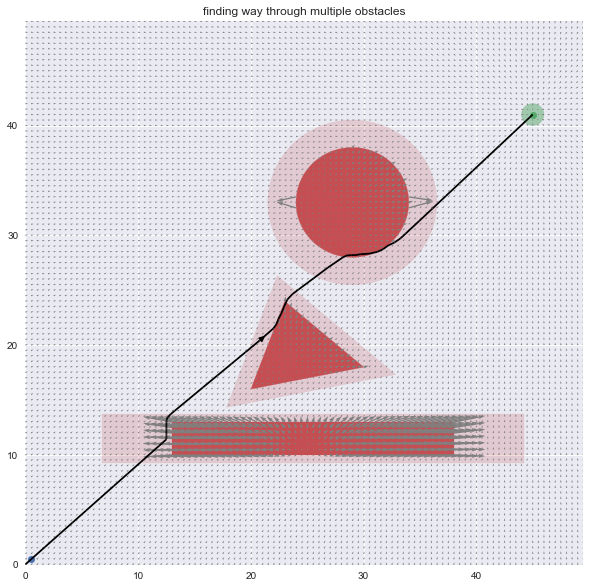

In [21]:
G = Graph()
G.add_obstacle(Obstacle(shape='circle', centre=(29, 33), radius=5, delta=0.5, k=2.2))
G.add_obstacle(Obstacle(shape='polygon', vertices=[(13, 10), (13, 13), (38, 13), (38, 10)], delta=0.5, k=1))
G.add_obstacle(Obstacle(shape='polygon', vertices=[(30, 18), (23, 24), (20, 16)], delta=0.5, k=2.5))
G.plot('finding way through multiple obstacles')

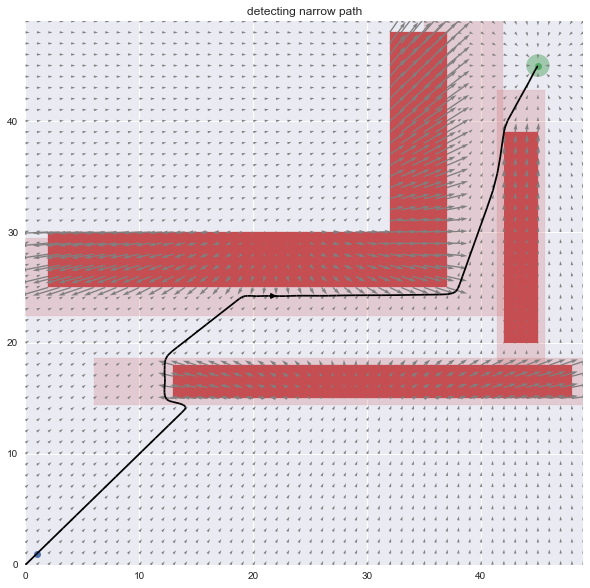

In [22]:
G = Graph(x_coords=np.arange(0, 50, 1), y_coords=np.arange(0, 50, 1), source_coords=(1, 1), dest_coords=(45, 45))
G.add_obstacle(Obstacle(shape='polygon', vertices=[(13, 15), (13, 18), (48, 18), (48, 15)], del_dist=2, delta=0.4, k=1))
G.add_obstacle(Obstacle(shape='polygon', vertices=[(2, 25), (2, 30), (32, 30), (32, 48), (37, 48), (37, 25)], del_dist=2, delta=0.4, k=0.5))
G.add_obstacle(Obstacle(shape='polygon', vertices=[(42, 20), (42, 39), (45, 39), (45, 20)], del_dist=2, delta=0.4, k=2.8))
G.plot('detecting narrow path')